Food insecurity is an important public health issue in both children and adults on a global and national scale.  Within the United States, the problem is most severe in the South where many factors, such as lack of resources and rural infrastructure, make the population more vulnerable to food insecurity.  North Carolina ranks 10th in the nation for child food insecurity with approximately 1 in every 5 children affected.  In this analysis, I have evaluated the prevalence of child food insecurity in North Carolina using income data from the American Community Survey (ACS) 2017 as well as food insecurity data from Feeding America 2017.

In [1]:
library('tidyverse')
library('ggthemes')
library('plotly')
Sys.setenv("plotly_username"="gkbecker")
Sys.setenv("plotly_api_key"="V6LfEEipk2daAcSvBTKH")
options(scipen = 5)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [2]:
nationalFI <- read.csv("https://raw.githubusercontent.com/gkbecker/BIOS512-assignments/master/AllData2017_MMG.csv")
nationalIncome <- read.csv("https://raw.githubusercontent.com/gkbecker/BIOS512-assignments/master/ACS_17_5YR_S1902.csv", skip = 1)

In [3]:
ncFI <- nationalFI %>%
        filter(State == "NC") %>%
        mutate(FI_Rate_Overall = as.numeric(sapply(X2017.Food.Insecurity.Rate, 
                                                   function(x) gsub("%", "", x)))) %>%
        mutate(FI_Rate_Children = as.numeric(sapply(X2017.Child.food.insecurity.rate, 
                                                   function(x) gsub("%", "", x)))) %>%
        mutate(Percent_Below185_Children = as.numeric(sapply(X..food.insecure.children.in.HH.w..HH.incomes.below.185.FPL.in.2017,
                                                             function(x) gsub("%", "", x)))) %>%
        mutate(County = sapply(County..State, function(x) gsub("(.*),.*", "\\1", x)))
nc_ChildRate <- ncFI %>%
        arrange(FI_Rate_Children) %>%
        mutate(County_ChildRate = factor(fct_inorder(County)))
topFI <- nc_ChildRate$County_ChildRate [order (nc_ChildRate$FI_Rate_Child, 
                                                   decreasing = TRUE)]
top3 <- c("#4d7ba1", "#4d7ba1", "#4d7ba1", "#4d7ba1", "#4d7ba1", "#4d7ba1", "#4d7ba1",
          "#73acd8", "#73acd8", "#73acd8")

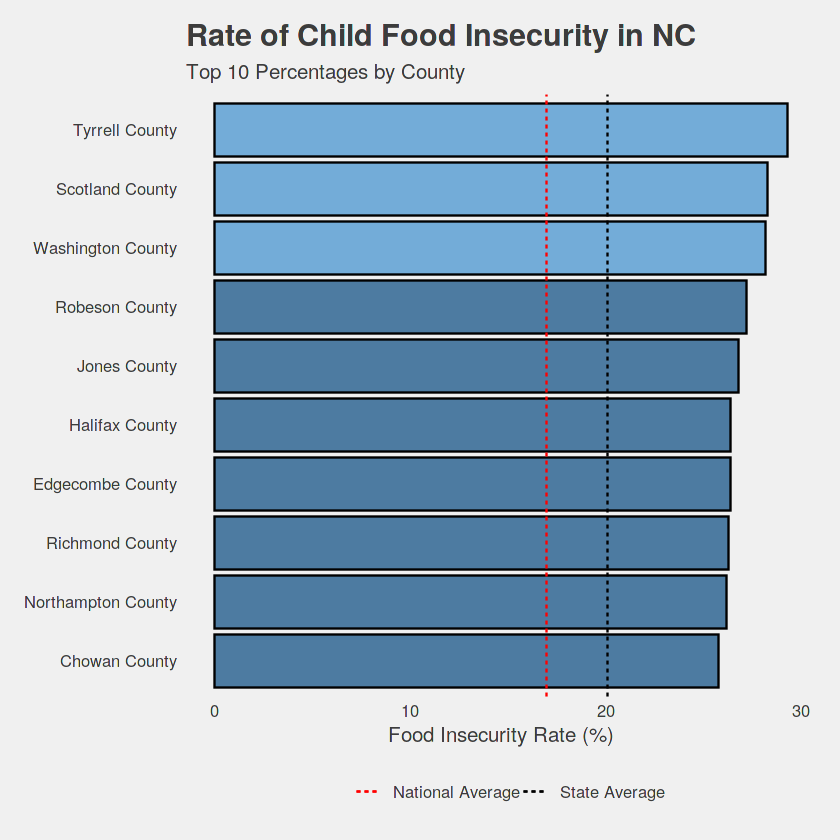

In [4]:
ggplot(data = subset (nc_ChildRate, County_ChildRate %in% topFI [1 : 10]), 
       aes(x = County_ChildRate, 
           y = FI_Rate_Children, 
           fill = County_ChildRate)) +
        geom_bar(stat = "identity",
                 colour = 'black') +
        coord_flip() +
        scale_fill_manual(values = top3, 
                          guide = FALSE) +
        ggtitle("Rate of Child Food Insecurity in NC", 
                subtitle = "Top 10 Percentages by County") +
        theme_fivethirtyeight() +
        theme(plot.title = element_text(face = "bold"), 
              panel.grid = element_blank(),
              axis.title = element_text(), 
              axis.title.y = element_blank()) +
        ylab("Food Insecurity Rate (%)") +
        geom_hline(aes(yintercept = 20.1, 
                       linetype = "State Average"), colour = "black") +
        geom_hline(aes(yintercept = 17, 
                       linetype = "National Average"), colour = "red") +
        scale_linetype_manual(name = "", values = c(2,2), 
                              guide = guide_legend(override.aes = list(color = c("red", "black"))))

Based on this graphic, we can can see that the top 10 counties are all about the national and state average for food insecurity rate.  Tyrell County has the highest prevalence of food insecurity in the state with nearly 30% of children struggling with food insecurity.

In [5]:
ncIncome <- nationalIncome %>%
        mutate(County = sapply(Geography, function(x) gsub("(.*),.*", "\\1", x))) %>%
        select(County, Mean_Income = Mean.income..dollars...Estimate..All.households) %>%
        mutate(Income_Group = ifelse(Mean_Income >= 80000, 5,
                                     ifelse(Mean_Income < 80000 & Mean_Income >= 70000, 4,
                                            ifelse(Mean_Income < 70000 & Mean_Income >= 60000, 3,
                                                   ifelse(Mean_Income < 60000 & Mean_Income >= 50000, 2,
                                                          ifelse(Mean_Income < 50000, 1, 0))))))
childData <- merge(nc_ChildRate, ncIncome, by = "County")
childData_Grouped <- childData %>%
        group_by(Income_Group) %>%
        summarize(Mean_FI_Child = mean(FI_Rate_Children))
k <- c("#045a8d", "#2b8cbe", "#74a9cf", "#a6bddb", "#d0d1e6")

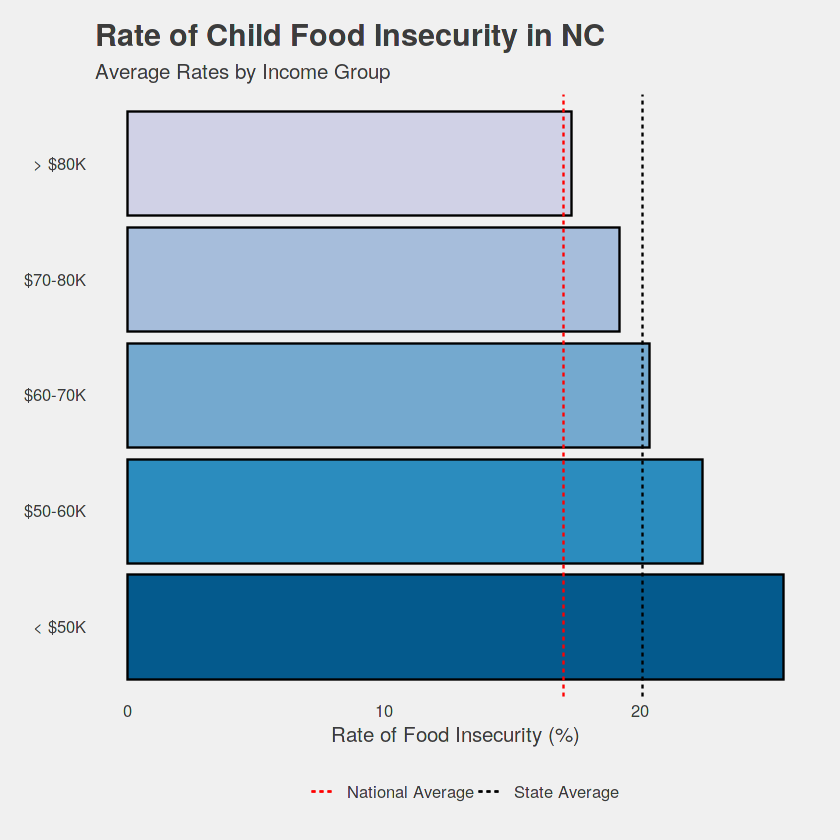

In [6]:
ggplot(childData_Grouped, aes(x = as.factor(Income_Group), 
                              y = Mean_FI_Child,
                              fill = as.factor(Income_Group))) +
        geom_bar(stat="identity", 
                 colour = 'black') +
        coord_flip() +
        ggtitle("Rate of Child Food Insecurity in NC", 
                subtitle = "Average Rates by Income Group") +
        scale_fill_manual(values = k, 
                          guide = FALSE) +
        theme_fivethirtyeight() +
        theme(plot.title = element_text(face = "bold"), 
              panel.grid = element_blank(),
              axis.title.y = element_blank(),
              axis.ticks.y = element_blank(),
              axis.title = element_text(),
              legend.position = "bottom") +
        scale_x_discrete(labels=c("5" = "> $80K", 
                                  "4" = "$70-80K", 
                                  "3" = "$60-70K", 
                                  "2" = "$50-60K", 
                                  "1" = "< $50K")) +
        ylab("Rate of Food Insecurity (%)") +
        geom_hline(aes(yintercept = 20.1, 
                       linetype = "State Average"), colour = "black") +
        geom_hline(aes(yintercept = 17, 
                       linetype = "National Average"), colour = "red") +
        scale_linetype_manual(name = "", values = c(2,2), 
                              guide = guide_legend(override.aes = list(color = c("red", "black"))))

This graphic lends insight into how food insecurity varies among the average household income of NC counties. This is interesting because it shows that even the highest income counties (average >$80,000), the average rate of child food insecurity is still greater than the national average.  This suggests that food insecurity in children is a multidimensional issue which does not depend solely on household income.

Within the field of public health, thorough data analysis is imperative to determine the priority areas for intervention and appropriately allocate resources.  These insights may be powerful in helping NC policymakers decide what areas should be targeted in addressing the problem of child food insecurity.